In [1]:
#this notebook is to train and test the CNN - transformer hybrid model from aves

#first we get the data and use pyha analyzer to convert it to spectograms
import datetime
import logging
import os
from typing import Any, Tuple, Optional

import numpy as np
import torch
import torch.nn.functional as F
from torch.amp.autocast_mode import autocast
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchmetrics.classification import MultilabelAveragePrecision
from tqdm import tqdm
import wandb
import pandas as pd
# from pyha_analyzer import config
# from pyha_analyzer.dataset import get_datasets, make_dataloaders, PyhaDFDataset
# from pyha_analyzer.utils import set_seed
# from pyha_analyzer.models.early_stopper import EarlyStopper

# tqdm.pandas()
# time_now  = datetime.datetime.now().strftime('%Y%m%d-%H%M')
# cfg = config.cfg
# logger = logging.getLogger("acoustic_multiclass_training")



In [2]:
data_dir = "/data/"

df = pd.read_csv('/data/132PeruXC_Chunks_gc_new_3.csv')

df.head()


,Unnamed: 0.6,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Unnamed: 0_x,OFFSET,DURATION,...,filename,download url,common,scientific,scientific (sub),Species eBird Code,Scientific Name,Common Name,file_location,fn_stripped
0,0,0,0,0,0,0,0,0,0.395349,5,...,XC100 - Grey-cowled Wood Rail - Aramides cajan...,https://xeno-canto.org/100/download,Grey-cowled Wood Rail,Aramides cajaneus,Aramides cajaneus,gycwor1,Aramides cajaneus,Gray-cowled Wood-Rail,132_peru_xc_BC_2020/XC100 - Grey-cowled Wood R...,XC100 - Grey-cowled Wood Rail - Aramides cajan...
1,1,1,1,1,1,1,0,0,2.895349,5,...,XC100 - Grey-cowled Wood Rail - Aramides cajan...,https://xeno-canto.org/100/download,Grey-cowled Wood Rail,Aramides cajaneus,Aramides cajaneus,gycwor1,Aramides cajaneus,Gray-cowled Wood-Rail,132_peru_xc_BC_2020/XC100 - Grey-cowled Wood R...,XC100 - Grey-cowled Wood Rail - Aramides cajan...
2,2,2,2,2,2,2,0,0,5.395349,5,...,XC100 - Grey-cowled Wood Rail - Aramides cajan...,https://xeno-canto.org/100/download,Grey-cowled Wood Rail,Aramides cajaneus,Aramides cajaneus,gycwor1,Aramides cajaneus,Gray-cowled Wood-Rail,132_peru_xc_BC_2020/XC100 - Grey-cowled Wood R...,XC100 - Grey-cowled Wood Rail - Aramides cajan...
3,3,3,3,3,3,3,0,0,7.895349,5,...,XC100 - Grey-cowled Wood Rail - Aramides cajan...,https://xeno-canto.org/100/download,Grey-cowled Wood Rail,Aramides cajaneus,Aramides cajaneus,gycwor1,Aramides cajaneus,Gray-cowled Wood-Rail,132_peru_xc_BC_2020/XC100 - Grey-cowled Wood R...,XC100 - Grey-cowled Wood Rail - Aramides cajan...
4,4,4,4,4,4,4,0,0,10.395349,5,...,XC100 - Grey-cowled Wood Rail - Aramides cajan...,https://xeno-canto.org/100/download,Grey-cowled Wood Rail,Aramides cajaneus,Aramides cajaneus,gycwor1,Aramides cajaneus,Gray-cowled Wood-Rail,132_peru_xc_BC_2020/XC100 - Grey-cowled Wood R...,XC100 - Grey-cowled Wood Rail - Aramides cajan...


In [3]:
#add /data/ to the file_location

df['file_location'] = data_dir + df['file_location']

In [4]:
#change column name file_location to file_path
df.rename(columns={'file_location': 'filepath'}, inplace=True)
df.rename(columns={'common': 'call_type'}, inplace=True)

In [5]:
#lets make a train set and a test set
#split the data into train and test by 80/20 ratio selecting random rows
df["partition"] = "test"
df.loc[df.sample(frac=0.8, random_state=42).index, "partition"] = "train"


In [6]:
#first we download the model weights and config:
!wget https://storage.googleapis.com/esp-public-files/ported_aves/aves-base-bio.torchaudio.pt
!wget https://storage.googleapis.com/esp-public-files/ported_aves/aves-base-bio.torchaudio.model_config.json


--2024-07-30 00:01:38--  https://storage.googleapis.com/esp-public-files/ported_aves/aves-base-bio.torchaudio.pt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.126.207, 74.125.132.207, 74.125.201.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.126.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 377570545 (360M) [application/octet-stream]
Saving to: ‘aves-base-bio.torchaudio.pt.2’

aves-base-bio.torch 100%[===================>] 360.08M   183MB/s    in 2.0s    

2024-07-30 00:01:40 (183 MB/s) - ‘aves-base-bio.torchaudio.pt.2’ saved [377570545/377570545]

--2024-07-30 00:01:40--  https://storage.googleapis.com/esp-public-files/ported_aves/aves-base-bio.torchaudio.model_config.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.126.207, 74.125.132.207, 74.125.201.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.126.207|:443... connected.
HTTP request sent, awai

In [7]:
import torch
import torch.nn as nn
import torchaudio
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [8]:
class Vox(Dataset):
    def __init__(self, dataset_dataframe, is_train, audio_sr, duration_sec, annotation_name):
        """ Dataset for vocalization classification with AVES

        Input
        -----
        dataset_dataframe (pandas dataframe): indicating the filepath, annotations and partition of a signal
        is_train (bool): True if in train set
        audio_sr (int): sampling rate expected by network
        duration_sec (float): pad/cut all clips to this duration to enable batching
        annotation_name (str): string corresponding to the annotation columns in the dataframe, e.g. "call_type"
        """
        super().__init__()
        self.audio_sr = audio_sr
        self.duration_sec = duration_sec
        self.dataset_partition = "train" if is_train else "test"
        self.annotation_name = annotation_name
        # Turn class annotations into integers from 0 - n_classes-1
        class_annotations = pd.Categorical(dataset_dataframe[annotation_name])
        self.classes = class_annotations.categories
        dataset_dataframe = dataset_dataframe.copy()
        dataset_dataframe[annotation_name + "_int"] = class_annotations.codes
        self.dataset_info = dataset_dataframe[dataset_dataframe["partition"] == self.dataset_partition]

    def __len__(self):
        return len(self.dataset_info)

    def get_one_item(self, idx):
      """ Load base audio """
      row = self.dataset_info.iloc[idx]
      x, sr = torchaudio.load(row["filepath"])
      if len(x.size()) == 2:
          x = x[0, :]
      if sr != self.audio_sr:
          x = torchaudio.functional.resample(x, sr, self.audio_sr)
      return x, row

    def pad_to_duration(self, x):
        """ Pad or clip x to a given duration """
        assert len(x.size()) == 1
        x_duration = x.size(0) / float(self.audio_sr)
        max_samples = int(self.audio_sr * self.duration_sec)
        if x_duration == self.duration_sec:
            return x
        elif x_duration < self.duration_sec:
            x = F.pad(x , (0, max_samples - x.size(0)), mode='constant')
            return x
        else:
            return x[:max_samples]

    def __getitem__(self, idx):
        x, row = self.get_one_item(idx)
        x = self.pad_to_duration(x)
        out = {"x" : x, "filepath" : row['filepath'], "filename" : row['filename']}
        out[self.annotation_name + "_str"] = row[self.annotation_name]
        out[self.annotation_name] = row[self.annotation_name + "_int"]
        return out

def get_dataloader(dataset_dataframe, is_train, audio_sr, duration_sec, labels, batch_size):
    return DataLoader(
            Vox(dataset_dataframe, is_train, audio_sr, duration_sec, labels),
            batch_size=batch_size,
            shuffle=is_train,
            drop_last=is_train
        )

In [9]:
import librosa
import matplotlib.pyplot as plt


  Dataset with 433934 datapoints
  Classes: Index(['? Amazonian', '? Barred', '? Bartlett's', '? Black-faced',
       '? Blue-crowned', '? Blue-headed', '? Buckley's', '? Buff-breasted',
       '? Buff-throated', '? Cinereous',
       ...
       'Trogon viridis', 'Turdus albicollis', 'Turdus hauxwelli',
       'Turdus ignobilis', 'Tyrannulus elatus', 'Veniliornis passerinus',
       'Xenops rutilans', 'Xiphorhynchus elegans', 'Xiphorhynchus guttatus',
       'Xiphorhynchus obsoletus'],
      dtype='object', length=166)



IndexError: index 8 is out of bounds for axis 0 with size 8

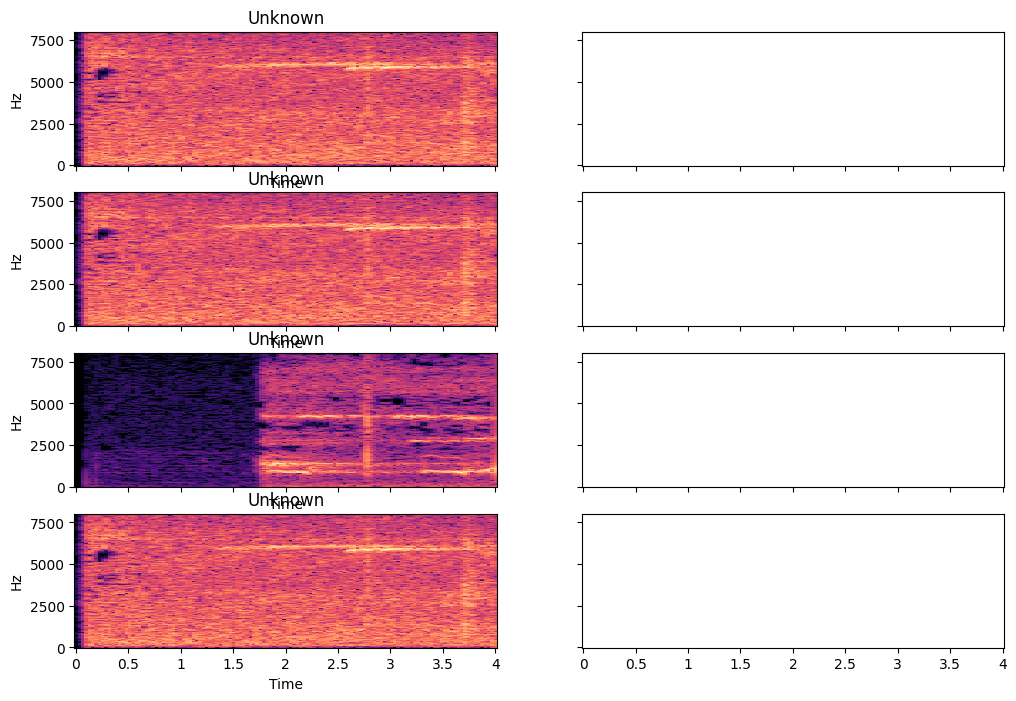

In [10]:
dataset_viz = Vox(df, True, 16000, 1.0, "scientific")
print(f"""
  Dataset with {len(dataset_viz)} datapoints
  Classes: {dataset_viz.classes}
""")
n_fft = 512
fig, axs = plt.subplots(4, 2, sharex=True, sharey=True, figsize=(12,8))
ax_idx = 0
for datapoint_idx in [10, 12, 8, 9, 20, 21, 45, 46]:
  ax = axs.flatten()[ax_idx]
  datapoint = dataset_viz[datapoint_idx]
  D = librosa.stft(datapoint["x"].numpy(), n_fft=n_fft)
  S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

  librosa.display.specshow(S_db, y_axis='linear', sr=16000,
                            x_axis='time', ax=ax, n_fft=n_fft)
  if "call_type_str" in datapoint:
    ax.set_title(datapoint["call_type_str"])
  else:
    ax.set_title("Unknown")

  ax_idx+=1
  ax_idx+=1
plt.tight_layout()

In [11]:
from torchaudio.models import wav2vec2_model
import json
import torch.nn as nn

In [12]:
class AvesClassifier(nn.Module):
    """ Uses AVES Hubert to embed sounds and classify """
    def __init__(self, config_path, model_path, n_classes, trainable, embedding_dim=768):
        super().__init__()
        # reference: https://pytorch.org/audio/stable/_modules/torchaudio/models/wav2vec2/utils/import_fairseq.html
        self.config = self.load_config(config_path)
        self.model = wav2vec2_model(**self.config, aux_num_out=None)
        self.model.load_state_dict(torch.load(model_path))
        # Freeze the AVES network
        self.trainable = trainable
        freeze_embedding_weights(self.model, trainable)
        # We will only train the classifier head
        self.classifier_head = nn.Linear(in_features=embedding_dim, out_features=n_classes)
        self.audio_sr = 16000

    def load_config(self, config_path):
        with open(config_path, 'r') as ff:
            obj = json.load(ff)
        return obj

    def forward(self, sig):
        """
        Input
          sig (Tensor): (batch, time)
        Returns
          mean_embedding (Tensor): (batch, output_dim)
          logits (Tensor): (batch, n_classes)
        """
        # extract_feature in the sorchaudio version will output all 12 layers' output, -1 to select the final one
        out = self.model.extract_features(sig)[0][-1]
        mean_embedding = out.mean(dim=1) #over time
        logits = self.classifier_head(mean_embedding)
        return mean_embedding, logits

In [13]:
# Code to use while initially setting up the model
def freeze_embedding_weights(model, trainable):
  """ Freeze weights in AVES embeddings for classification """
  # The convolutional layers should never be trainable
  model.feature_extractor.requires_grad_(False)
  model.feature_extractor.eval()
  # The transformers are optionally trainable
  for param in model.encoder.parameters():
    param.requires_grad = trainable
  if not trainable:
    # We also set layers without params (like dropout) to eval mode, so they do not change
    model.encoder.eval()


# Code to use during training loop, to switch between eval and train mode
def set_eval_aves(model):
  """ Set AVES-based classifier to eval mode. Takes into account whether we are training transformers """
  model.classifier_head.eval()
  model.model.encoder.eval()

def set_train_aves(model):
  """ Set AVES-based classifier to train mode. Takes into account whether we are training transformers """
  # Always train the classifier head
  model.classifier_head.train()
  # Optionally train the transformer of the model
  if model.trainable:
      model.model.encoder.train()

In [20]:
from tqdm import tqdm

def train_one_epoch(model, dataloader, optimizer, loss_function):
    set_train_aves(model)
    loss_function = nn.CrossEntropyLoss()

    epoch_losses = []
    iterator = tqdm(dataloader)
    for i, batch_dict in enumerate(iterator):
        print(f"Processing batch {i+1}/{len(dataloader)}")
        optimizer.zero_grad()
        if torch.cuda.is_available():
            batch_dict["x"] = batch_dict["x"].cuda()
            batch_dict[dataloader.dataset.annotation_name] = batch_dict[dataloader.dataset.annotation_name].cuda()

        print("Input tensor shape:", batch_dict["x"].shape)  # Print input shape

        embedding, logits = model(batch_dict["x"])

        print("Logits tensor shape:", logits.shape)  # Print logits shape
        print("Targets tensor shape:", batch_dict[dataloader.dataset.annotation_name].shape)  # Print targets shape

        loss = loss_function(logits, batch_dict[dataloader.dataset.annotation_name].to(torch.long))
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        if len(epoch_losses) > 10:
            iterator.set_description(f"Train loss: {np.mean(epoch_losses[-10:]):.3f}")

    return epoch_losses


In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

def test_one_epoch(model, dataloader, loss_function, epoch_idx):
  """ Obtain loss and F1 scores on test set """

  set_eval_aves(model)

  # Obtain predictions
  all_losses = []
  all_predictions = []
  with torch.no_grad():
    for i, batch_dict in enumerate(dataloader):
        if torch.cuda.is_available():
          batch_dict["x"] = batch_dict["x"].cuda()
          batch_dict[dataloader.dataset.annotation_name] = batch_dict[dataloader.dataset.annotation_name].cuda()
        embedding, logits = model(batch_dict["x"])
        all_losses.append(loss_function(logits, batch_dict[dataloader.dataset.annotation_name].to(torch.long)))
        all_predictions.append(logits.argmax(1))

  # Format predictions and annotations
  all_losses = torch.stack(all_losses)
  all_predictions = torch.cat(all_predictions).cpu().numpy()
  all_annotations = dataloader.dataset.dataset_info[dataloader.dataset.annotation_name + "_int"].to_numpy() # since dataloader shuffle = False
  # Get confusion matrix
  cm = confusion_matrix(all_annotations, all_predictions)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataloader.dataset.classes)
  disp.plot()
  disp.ax_.set_title(f"Test epoch {epoch_idx}")
  # Compute F1
  f1_scores = f1_score(all_annotations, all_predictions, average=None)
  macro_average_f1 = f1_score(all_annotations, all_predictions, average="macro")
  # Report
  print(f"Mean test loss: {all_losses.mean():.3f}, Macro-average F1: {macro_average_f1:.3f}")
  print("F1 by class:")
  print({k: np.round(s,decimals=4) for (k,s) in zip(dataloader.dataset.classes, f1_scores)})
  return

In [22]:
def run(
      dataset_dataframe,
      model_path,
      model_config_path,
      duration_sec,
      annotation_name,
      learning_rate,
      batch_size,
      n_epochs,
      aves_sr = 16000
      ):

  print("Setting up dataloaders")
  train_dataloader = get_dataloader(dataset_dataframe, True, aves_sr, duration_sec, annotation_name, batch_size)
  test_dataloader = get_dataloader(dataset_dataframe, False, aves_sr, duration_sec, annotation_name, batch_size)

  print("Setting up model")
  model = AvesClassifier(model_config_path, model_path, len(train_dataloader.dataset.classes), False)
  if torch.cuda.is_available():
    model.cuda()

  print("Setting up optimizers")
  optimizer = torch.optim.Adam(model.classifier_head.parameters(), lr=learning_rate)

  print("Setting up loss function")
  loss_function = nn.CrossEntropyLoss()

  for epoch_idx in range(n_epochs):
    print(f"~~ Training epoch {epoch_idx}")
    train_one_epoch(model, train_dataloader, optimizer, loss_function)
    print(f"~~ Testing epoch {epoch_idx}")
    test_one_epoch(model, test_dataloader, loss_function, epoch_idx)

  return

In [23]:
run(
      dataset_dataframe=df,
      model_path="aves-base-bio.torchaudio.pt",
      model_config_path="aves-base-bio.torchaudio.model_config.json",
      duration_sec=1.0,
      annotation_name="call_type",
      learning_rate=1e-3,
      batch_size=20,
      n_epochs=10
    )

Setting up dataloaders
Setting up model
Setting up optimizers
Setting up loss function
~~ Training epoch 0


  0%|          | 1/21696 [00:04<27:57:41,  4.64s/it]

Processing batch 1/21696
Input tensor shape: torch.Size([20, 16000])
Logits tensor shape: torch.Size([20, 132])
Targets tensor shape: torch.Size([20])


  0%|          | 2/21696 [00:08<23:27:40,  3.89s/it]

Processing batch 2/21696
Input tensor shape: torch.Size([20, 16000])
Logits tensor shape: torch.Size([20, 132])
Targets tensor shape: torch.Size([20])


  0%|          | 3/21696 [00:11<21:38:58,  3.59s/it]

Processing batch 3/21696
Input tensor shape: torch.Size([20, 16000])
Logits tensor shape: torch.Size([20, 132])
Targets tensor shape: torch.Size([20])


  0%|          | 4/21696 [00:16<24:47:21,  4.11s/it]

Processing batch 4/21696
Input tensor shape: torch.Size([20, 16000])
Logits tensor shape: torch.Size([20, 132])
Targets tensor shape: torch.Size([20])


  0%|          | 5/21696 [00:20<25:23:52,  4.22s/it]

Processing batch 5/21696
Input tensor shape: torch.Size([20, 16000])
Logits tensor shape: torch.Size([20, 132])
Targets tensor shape: torch.Size([20])


  0%|          | 6/21696 [00:25<26:27:57,  4.39s/it]

Processing batch 6/21696
Input tensor shape: torch.Size([20, 16000])
Logits tensor shape: torch.Size([20, 132])
Targets tensor shape: torch.Size([20])


  0%|          | 7/21696 [00:28<25:01:27,  4.15s/it]

Processing batch 7/21696
Input tensor shape: torch.Size([20, 16000])
Logits tensor shape: torch.Size([20, 132])
Targets tensor shape: torch.Size([20])


  0%|          | 8/21696 [00:32<24:30:40,  4.07s/it]

Processing batch 8/21696
Input tensor shape: torch.Size([20, 16000])
Logits tensor shape: torch.Size([20, 132])
Targets tensor shape: torch.Size([20])


  0%|          | 9/21696 [00:34<20:52:31,  3.47s/it]

Processing batch 9/21696
Input tensor shape: torch.Size([20, 16000])
Logits tensor shape: torch.Size([20, 132])
Targets tensor shape: torch.Size([20])


  0%|          | 9/21696 [00:35<23:42:55,  3.94s/it]


RuntimeError: Failed to process a packet. (Invalid data found when processing input). 